## Class 5 - Bagging and Boosting

### Recap of lecture and introductory remarks
In yesterday's lecture, we introduced bagging and boosting as two techniques to reduce variance and reduce variance of decision trees. Bagging and boosting are not specific to decision trees, but we will see them in action with this kind of model.

We used bagging to train a set of small decision trees (weak learners) on subsets of the training data, whose individual predictions we aggregate to make a single prediction. The resulting model is an _ensemble_ model. We have seen that `Random Forests` are popular learning algorithms that combine bagging with random sampling of features, to induce diversity in decision trees and further regularization.

On the other hand, boosting consists in training a sequence of decision trees which iteratively reduce the error of the previous decision tree because they are fitted on the residuals or on the gradients of the previous tree. We have focused specifically on `gradient boosting` and indicated `XGBoost` as a particularly powerful implementation of boosting + bagging.

Today, we will go back to the bike data, and fit `RandomForest` and `XGBoost` models, comparing their performances to those of models fitted previously. We will implement Random Forests using `scikit-learn`, and XGBoost using the XGBoost package: https://xgboost.readthedocs.io/en/stable/ 

**Note**: As last week, under `nbs/class_05` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on sample data.

### Operational remarks
Two suggestions on how to go about this, based on where you are at regarding exercises from previous weeks.

If you have done exercises from class 2 and 3, you will have one/two notebooks with baseline, linear, KNN, and linear regularized models, as well as records of performances (which will be handy to compare performances of our new methods). In this case, my suggestion would be to work on a new notebook where you only fit the new models, and load the performance of the old models for comparison.

If you have not done exercises from previous classes, you have two options:
- Work on a new notebook and "manually" compare the performance of your new models to plots from previous weeks;
- Work on a new notebook and also implement a couple of models from previous weeks for comparison.

### Today's exercise
Work in groups on the following tasks

1. Fit a `Random Forest` model to the data (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor), using cross-validation to define the best possible range of parameters
    - There are a number of parameters that should be passed to the estimator. Carefully read the documentation, and identify a few hyperparameters you might want to manipulate
    - Define a series of possible values for these hyperparameters, and store this information into a Python dictionary. For each hyperparameter, the dictionary should include the name of the hyperparameters (as a string) as `key`, and a list including a range of possible values as `value`
    - Pass your estimator and the parameter grid to `GridSearchCV`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html and fit this object to your training set. If you have defined *a lot* of possible values, you can consider using `RandomizedSearchCV`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html. **Note**: you need to pass something appropriate as the value of the `scoring` argument
    - Try to answer the following questions:
        - What is `GridSearchCV` doing?
        - What is the difference between `RandomizedSearchCV` and `GridSearchCV`?
        - **Bonus question**: Given that we do have a validation set, could we do model selection without using cross-validation? Which parameter in `GridSearchCV` or `RandomizedSearchCV` would you have to change, and how, to do so?
    - Find out which hyperparameters gave the best result
        - **Hint**: look at the `.best_estimator_` attribute on a fitted `GridSearchCV`/`RandomizedSearchCV` and `.get_params()`
    - Compute the performance of this model on the training, validation, and test set
    - Compute and plot feature importances for the resulting model. You can look at the `.feature_importances_` attribute of the best estimator.
        - **Bonus question**: which method is used by default to compute feature importances? Is any other method available in `sklearn`?

2. Do the exact same things as 1., this time using `XGBRegressor` (https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)
    - Note: you will have to install `xgboost` (https://xgboost.readthedocs.io/en/stable/install.html) to run this
    - You will have to define an appropriate `scoring` parameter
    - Parameters for grid/randomized search will be slightly different: look at the documentation for XGBRegressor, and make informed choices based on what we discussed in class

3. Plot the performance of the best Random Forest models and the best XGBoost models, against models you fitted previously
    - Which models perform best?
    - How does the performance profile of RandomForest compare to XGBoost? Why?

4. Compare feature importances across `RandomForest` and `XGBoost`: do they look similar/different?

5. Overall reflection on modeling process
    - Reflect back on your choices for previous models: should you have transformed any of the features before fitting Linear Regression, KNN, or regularized models?
    - Can you think of ways in which our predictive problem can be made more interesting from a business perspective?
    - Which aspect of the data are we *not* modeling, that we could/should model?

In [1]:
import os
import pandas as pd

path = os.path.join("..","..","_data", "bike_sharing_dataset", "day.csv")
df = pd.read_csv(path)

# make date column datetime
df['dteday'] = pd.to_datetime(df['dteday'])
# remove date column
df = df.drop(columns=['dteday', 'registered', 'casual'])

print(df.columns)
# removing everything not related to weather
df = df.drop(columns=['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'instant']) 

print(df.columns)

Index(['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')
Index(['weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_70685/1802960898.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# fit random forest model to the data using cross validation to define best possible range of hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# split the data into training and test set
X = df.drop(columns=["cnt"])
y = df["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 80% training and 20% validation

# define the model
model = RandomForestRegressor()

# define the grid of hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200], # number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40], # maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20], # minimum number of samples required to split an internal node meaning the higher the number the less likely the model is to overfit
    'min_samples_leaf': [1, 2, 4, 8], # minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', None] # number of features to consider when looking for the best split
}

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1) # neg_mean_squared_error is the metric to be used to evaluate the model

# fit the model
grid_search.fit(X_train, y_train)  # Assuming you have already split your data into X_train and y_train beforehand

#What is GridSearchCV doing?
#GridSearchCV is systematically working through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [3]:
# Best hyperparameters
best_rf = grid_search.best_estimator_

# Getting the hyperparameters of the best model
best_params = best_rf.get_params()

best_rf

RandomForestRegressor(max_depth=10, max_features='sqrt')

In [4]:
# Computing performance
from sklearn.metrics import mean_squared_error

# Predictions
y_train_pred = best_rf.predict(X_train)
y_valid_pred = best_rf.predict(X_val)
y_test_pred = best_rf.predict(X_test)

# Calculating the performance with rmse and r2
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_val, y_valid_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# put the performances in a dataframe
random_forrest_performance = pd.DataFrame({
    "Train_RMSE": [train_rmse],
    "Validation_RMSE": [valid_rmse],
    "Test_RMSE": [test_rmse]
})
random_forrest_performance

/Users/wibe/Desktop/CogSci/Data Science/DataSci-AU-24/venv_data_science_2024/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/wibe/Desktop/CogSci/Data Science/DataSci-AU-24/venv_data_science_2024/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/wibe/Desktop/CogSci/Data Science/DataSci-AU-24/venv_data_science_2024/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Train_RMSE,Validation_RMSE,Test_RMSE
0,628.681758,1230.973025,1410.697


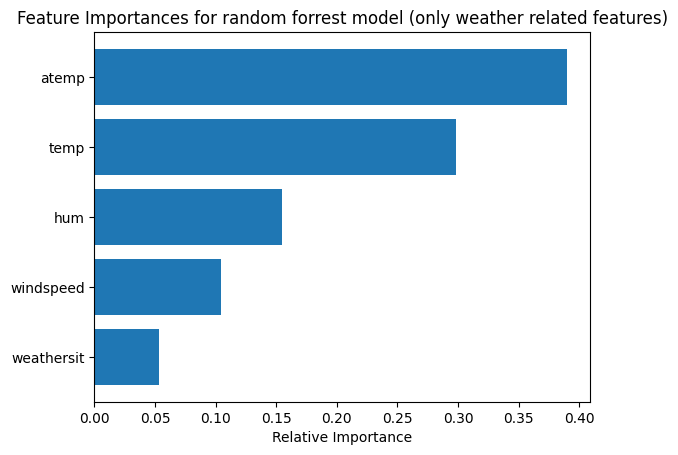

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# the feature names
feature_names = X.columns

feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)

# Assuming you have a list 'feature_names' that corresponds to the column names
plt.title('Feature Importances for random forrest model (only weather related features)')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Now using XGBRegressor

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# defining model
xg_reg = xgb.XGBRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500], # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'max_depth' : [2, 3, 5, 10], # Maximum tree depth for base learners.
    'objective': ['reg:squarederror'], # Specify the learning task and the corresponding learning objective or a custom objective function to be used
    'colsample_bytree': [0.3, 0.6, 0.9], # Subsample ratio of columns when constructing each tree.
    'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1] # Step size shrinkage used in update to prevents overfitting
}

grid_search = GridSearchCV(estimator=xg_reg, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=2, 
                           n_jobs=-1)

# fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=10, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=20, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=20, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=10, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=20, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=20, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=2e-05, max_depth=2, n_estimators=20, objective=reg:squarederror; total time=   0.0s
[CV] END colsample_bytree=0.3, le

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.6, 0.9],
                         'learning_rate': [2e-05, 0.0002, 0.002, 0.02, 0.2],
                         'max_depth': [2, 3, 5, 10],
                         'n_estimators': [10, 20, 100, 200, 500],
                         'objective': ['reg:squarederror']},
             scoring='neg_mean_squared_error', verbose=2)

In [7]:
# Best hyperparameters
best_xgb = grid_search.best_estimator_

# Getting the hyperparameters of the best model
best_params = best_xgb.get_params()

best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# Computing performance
from sklearn.metrics import mean_squared_error

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_valid_pred = best_xgb.predict(X_val)
y_test_pred = best_xgb.predict(X_test)

# Calculating the performance (RMSE)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False) # squared=False returns the root mean squared error
valid_rmse = mean_squared_error(y_val, y_valid_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# putting the performances in a dataframe
xgboost_performance = pd.DataFrame({
    "Train_RMSE": [train_rmse],
    "Validation_RMSE": [valid_rmse],
    "Test_RMSE": [test_rmse]
})

print("XGBoost performance")
print(xgboost_performance)
print("random forrest performance")
print(random_forrest_performance)

XGBoost performance
    Train_RMSE  Validation_RMSE    Test_RMSE
0  1026.105309      1291.510582  1357.877384
random forrest performance
   Train_RMSE  Validation_RMSE  Test_RMSE
0  628.681758      1230.973025   1410.697


/Users/wibe/Desktop/CogSci/Data Science/DataSci-AU-24/venv_data_science_2024/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/wibe/Desktop/CogSci/Data Science/DataSci-AU-24/venv_data_science_2024/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/wibe/Desktop/CogSci/Data Science/DataSci-AU-24/venv_data_science_2024/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


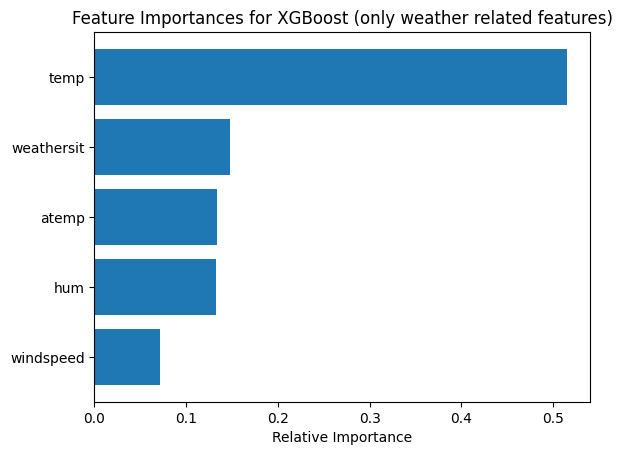

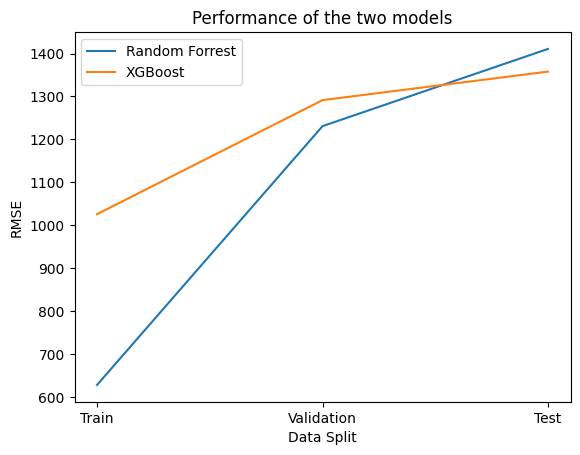

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# the feature names
feature_names = X.columns

feature_importances = best_xgb.feature_importances_
indices = np.argsort(feature_importances)

plt.title('Feature Importances for XGBoost (only weather related features)')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# plot the performance of the two models
fig, ax = plt.subplots()
x = ["Train", "Validation", "Test"]
ax.plot(x, random_forrest_performance.iloc[0], label="Random Forrest")
ax.plot(x, xgboost_performance.iloc[0], label="XGBoost")
ax.set_xlabel("Data Split")
ax.set_ylabel("RMSE")
ax.set_title("Performance of the two models")
ax.legend()
plt.show()